In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
import math
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [2]:
# dataset from http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/diabetes.html

### These data are courtesy of Dr John Schorling, Department of Medicine, University of Virginia School of Medicine.

### The data consist of 19 variables on 403 subjects from 1046 subjects who were interviewed in a study to understand the prevalence of obesity, diabetes, and other cardiovascular risk factors in central Virginia for African Americans. According to Dr John Hong, Diabetes Mellitus Type II (adult onset diabetes) is associated most strongly with obesity. The waist/hip ratio may be a predictor in diabetes and heart disease. DM II is also agssociated with hypertension - they may both be part of "Syndrome X". The 403 subjects were the ones who were actually screened for diabetes. Glycosolated hemoglobin > 7.0 is usually taken as a positive diagnosis of diabetes. For more information about this study see 

### Willems JP, Saunders JT, DE Hunt, JB Schorling: Prevalence of coronary heart disease risk factors among rural blacks: A community-based study. Southern Medical Journal 90:814-820; 1997 

### and

### Schorling JB, Roach J, Siegel M, Baturka N, Hunt DE, Guterbock TM, Stewart HL: A trial of church-based smoking cessation interventions for rural African Americans. Preventive Medicine 26:92-101; 1997.



In [3]:
df = pd.read_csv('diabetes.csv')
df.head(10)

,id,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn
0,1000,203.0,82,56.0,3.6,4.31,Buckingham,46,female,62.0,121.0,medium,118.0,59.0,NaN,NaN,29.0,38.0,720.0
1,1001,165.0,97,24.0,6.9,4.44,Buckingham,29,female,64.0,218.0,large,112.0,68.0,NaN,NaN,46.0,48.0,360.0
2,1002,228.0,92,37.0,6.2,4.64,Buckingham,58,female,61.0,256.0,large,190.0,92.0,185.0,92.0,49.0,57.0,180.0
3,1003,78.0,93,12.0,6.5,4.63,Buckingham,67,male,67.0,119.0,large,110.0,50.0,NaN,NaN,33.0,38.0,480.0
4,1005,249.0,90,28.0,8.9,7.72,Buckingham,64,male,68.0,183.0,medium,138.0,80.0,NaN,NaN,44.0,41.0,300.0
5,1008,248.0,94,69.0,3.6,4.81,Buckingham,34,male,71.0,190.0,large,132.0,86.0,NaN,NaN,36.0,42.0,195.0
6,1011,195.0,92,41.0,4.8,4.84,Buckingham,30,male,69.0,191.0,medium,161.0,112.0,161.0,112.0,46.0,49.0,720.0
7,1015,227.0,75,44.0,5.2,3.94,Buckingham,37,male,59.0,170.0,medium,NaN,NaN,NaN,NaN,34.0,39.0,1020.0
8,1016,177.0,87,49.0,3.6,4.84,Buckingham,45,male,69.0,166.0,large,160.0,80.0,128.0,86.0,34.0,40.0,300.0
9,1022,263.0,89,40.0,6.6,5.78,Buckingham,55,female,63.0,202.0,small,108.0,72.0,NaN,NaN,45.0,50.0,240.0


In [4]:
df.shape

(403, 19)

In [5]:
df.columns

Index(['id', 'chol', 'stab.glu', 'hdl', 'ratio', 'glyhb', 'location', 'age',
       'gender', 'height', 'weight', 'frame', 'bp.1s', 'bp.1d', 'bp.2s',
       'bp.2d', 'waist', 'hip', 'time.ppn'],
      dtype='object')

In [6]:
df.dtypes

id            int64
chol        float64
stab.glu      int64
hdl         float64
ratio       float64
glyhb       float64
location     object
age           int64
gender       object
height      float64
weight      float64
frame        object
bp.1s       float64
bp.1d       float64
bp.2s       float64
bp.2d       float64
waist       float64
hip         float64
time.ppn    float64
dtype: object

In [7]:
df.isnull().sum()

id            0
chol          1
stab.glu      0
hdl           1
ratio         1
glyhb        13
location      0
age           0
gender        0
height        5
weight        1
frame        12
bp.1s         5
bp.1d         5
bp.2s       262
bp.2d       262
waist         2
hip           2
time.ppn      3
dtype: int64

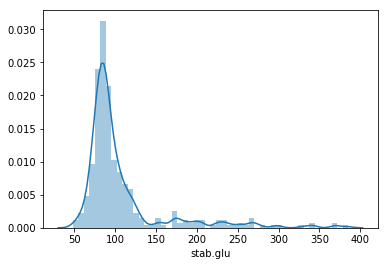

In [8]:
sns.distplot(df['stab.glu'])

In [9]:
df.glyhb.describe()

count    390.000000
mean       5.589769
std        2.242595
min        2.680000
25%        4.380000
50%        4.840000
75%        5.600000
max       16.110001
Name: glyhb, dtype: float64

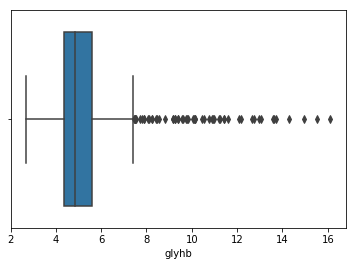

In [10]:
sns.boxplot(df['glyhb'])

In [11]:
# create a function to create a categorical column for the dataframe
# based on levels of glycated hemoglobin
def diabetes_cat(glyhb):
    if glyhb >= 6.5:
        return 1
    else:
        return 0

In [12]:
# create a new column in dataframe, 'Outcome' where 1 indicates diabetes & 0 indicates non-diabetic
df['Outcome'] = df['glyhb'].apply(diabetes_cat)

In [13]:
df.head(3)

,id,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn,Outcome
0,1000,203.0,82,56.0,3.6,4.31,Buckingham,46,female,62.0,121.0,medium,118.0,59.0,NaN,NaN,29.0,38.0,720.0,0
1,1001,165.0,97,24.0,6.9,4.44,Buckingham,29,female,64.0,218.0,large,112.0,68.0,NaN,NaN,46.0,48.0,360.0,0
2,1002,228.0,92,37.0,6.2,4.64,Buckingham,58,female,61.0,256.0,large,190.0,92.0,185.0,92.0,49.0,57.0,180.0,0


In [14]:
#df = df.fillna(0)
# replace nans in columns with mean value in columns
df=df.fillna(df.mean())
df.head(3)

,id,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn,Outcome
0,1000,203.0,82,56.0,3.6,4.31,Buckingham,46,female,62.0,121.0,medium,118.0,59.0,152.382979,92.524823,29.0,38.0,720.0,0
1,1001,165.0,97,24.0,6.9,4.44,Buckingham,29,female,64.0,218.0,large,112.0,68.0,152.382979,92.524823,46.0,48.0,360.0,0
2,1002,228.0,92,37.0,6.2,4.64,Buckingham,58,female,61.0,256.0,large,190.0,92.0,185.000000,92.000000,49.0,57.0,180.0,0


In [15]:
df.isnull().sum()

id           0
chol         0
stab.glu     0
hdl          0
ratio        0
glyhb        0
location     0
age          0
gender       0
height       0
weight       0
frame       12
bp.1s        0
bp.1d        0
bp.2s        0
bp.2d        0
waist        0
hip          0
time.ppn     0
Outcome      0
dtype: int64

## Exploratory Data Analysis

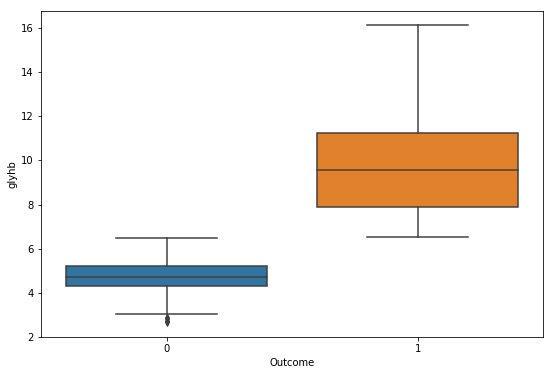

In [16]:
plt.figure(figsize = [9,6])
sns.boxplot(x="Outcome", y="glyhb", data= df)

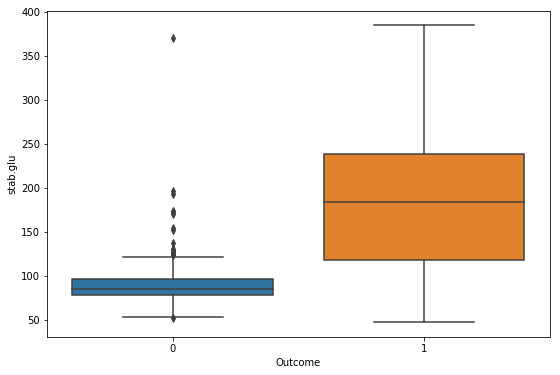

In [17]:
plt.figure(figsize = [9,6])
sns.boxplot(x="Outcome", y="stab.glu", data= df)

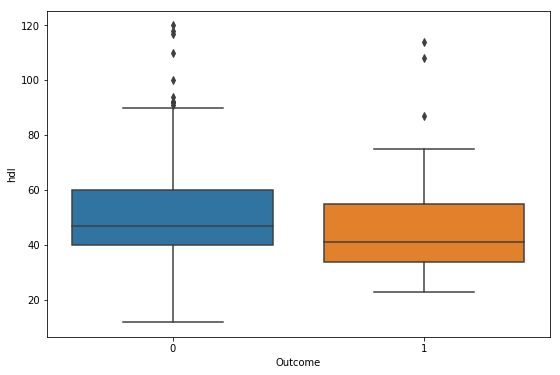

In [18]:
plt.figure(figsize = [9,6])
sns.boxplot(x="Outcome", y="hdl", data= df)

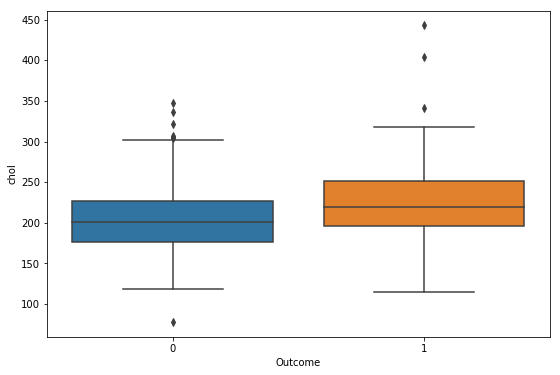

In [19]:
plt.figure(figsize = [9,6])
sns.boxplot(x="Outcome", y="chol", data= df)

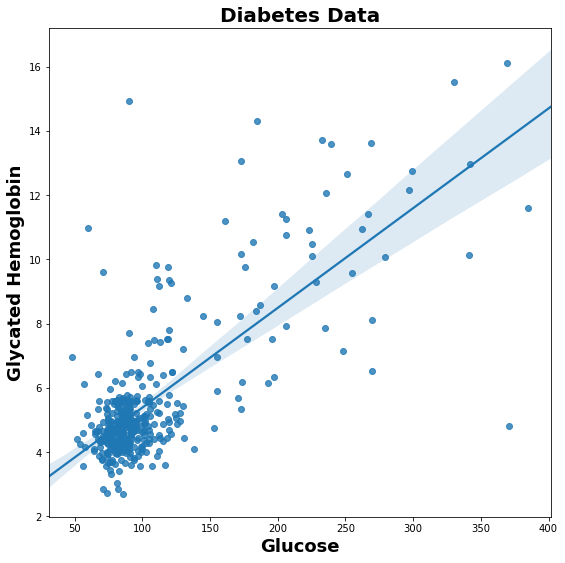

In [20]:
plt.figure(figsize = [9,9]) # [width, height]
plt.title('Diabetes Data',weight = 'bold', size =20)
sns.regplot(x="stab.glu", y="glyhb", data = df)
plt.xlabel('Glucose', weight = 'bold',size =18)
plt.ylabel('Glycated Hemoglobin', weight = 'bold', size=18)

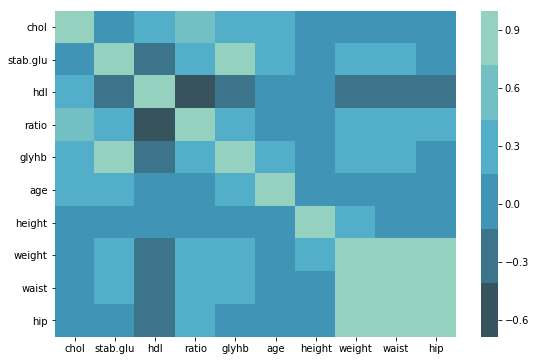

In [21]:
my_columns = ['chol', 'stab.glu', 'hdl', 'ratio', 'glyhb', 'age',
       'gender', 'height', 'weight', 'frame','waist', 'hip']
df_1 = df[my_columns]
corr = df_1.corr()
plt.figure(figsize = [9,6]) 

sns.heatmap(corr,cmap = sns.color_palette("GnBu_d"),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [35]:
corr

,chol,stab.glu,hdl,ratio,glyhb,age,height,weight,waist,hip
chol,1.000000,0.150021,0.186581,0.475521,0.244407,0.233118,-0.058324,0.066239,0.123726,0.078967
stab.glu,0.150021,1.000000,-0.161823,0.280216,0.747041,0.289258,0.090315,0.184010,0.218297,0.133411
hdl,0.186581,-0.161823,1.000000,-0.686907,-0.146987,0.038087,-0.100981,-0.289370,-0.266577,-0.208785
ratio,0.475521,0.280216,-0.686907,1.000000,0.325137,0.148509,0.094176,0.280148,0.301908,0.193302
glyhb,0.244407,0.747041,-0.146987,0.325137,1.000000,0.335930,0.061628,0.166749,0.223218,0.138550
age,0.233118,0.289258,0.038087,0.148509,0.335930,1.000000,-0.090358,-0.055937,0.149434,0.008807
height,-0.058324,0.090315,-0.100981,0.094176,0.061628,-0.090358,1.000000,0.249728,0.050888,-0.106813
weight,0.066239,0.184010,-0.289370,0.280148,0.166749,-0.055937,0.249728,1.000000,0.846362,0.826496
waist,0.123726,0.218297,-0.266577,0.301908,0.223218,0.149434,0.050888,0.846362,1.000000,0.837080
hip,0.078967,0.133411,-0.208785,0.193302,0.138550,0.008807,-0.106813,0.826496,0.837080,1.000000


## Logistic Regression Model for Classification

In [22]:
predictors = ['chol', 'stab.glu', 'hdl', 'ratio', 'glyhb', 'age',
              'height', 'weight','bp.1s', 'bp.1d', 'bp.2s',
              'bp.2d', 'waist', 'hip', 'time.ppn']
#predictors = [ 'glyhb']

print(len(predictors))

15


In [23]:
# create training and testing data
y = df.Outcome
X = df[predictors]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(322, 15) (322,)
(81, 15) (81,)


In [24]:
#X_test

In [25]:
#y_test

In [26]:
# Logistic Regression to predict diabetes with glylhb data
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print("Score for test data: {:.2f}".format(lr.score(X_test, y_test)))

Score for test data: 0.98


In [27]:
# Create another model without glyhb data
predictors2 = ['chol', 'stab.glu', 'hdl', 'ratio', 'age',
              'height', 'weight','bp.1s', 'bp.1d', 'bp.2s',
              'bp.2d', 'waist', 'hip', 'time.ppn']


# create training and testing data
y = df.Outcome
X = df[predictors2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print()
# Logistic Regression to predict diabetes
lr2 = LogisticRegression()
lr2.fit(X_train, y_train)
predictions = lr2.predict(X_test)
print("Score for test data: {:.2f}".format(lr2.score(X_test, y_test)))

(322, 14) (322,)
(81, 14) (81,)

Score for test data: 0.91


In [28]:
# Create another model without glyhb data
#predictors3 = ['chol', 'stab.glu', 'hdl', 'ratio', 'age',
              #'height', 'weight','waist', 'hip', 'time.ppn']
predictors3 = ['chol', 'stab.glu', 'hdl', 'ratio', 'age',
              'height', 'weight','waist', 'hip']

# create training and testing data
y = df.Outcome
X = df[predictors3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Logistic Regression to predict diabetes
lr3 = LogisticRegression()
lr3.fit(X_train, y_train)
predictions = lr3.predict(X_test)
print("Score for test data: {:.2f}".format(lr3.score(X_test, y_test)))

(322, 9) (322,)
(81, 9) (81,)
Score for test data: 0.91


In [29]:
# Create model without glyhb data
predictors4 = ['chol', 'stab.glu', 'height', 'weight','bp.1s', 'bp.1d', 'bp.2s',
               'bp.2d', 'waist', 'hip', 'time.ppn']

# create training and testing data
y = df.Outcome
X = df[predictors4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print()
# Logistic Regression to predict diabetes
lr4 = LogisticRegression()
lr4.fit(X_train, y_train)
predictions = lr4.predict(X_test)
print("Score for test data: {:.2f}".format(lr4.score(X_test, y_test)))

(322, 11) (322,)
(81, 11) (81,)

Score for test data: 0.91


In [30]:
predictors5 = ['chol', 'stab.glu', 'hdl', 'ratio', 'age',
              'height', 'weight']
# create training and testing data
y = df.Outcome
X = df[predictors5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print()

# Logistic Regression to predict diabetes
lr5 = LogisticRegression()
lr5.fit(X_train, y_train)
predictions = lr5.predict(X_test)
print("Score for test data: {:.2f}".format(lr5.score(X_test, y_test)))

(322, 7) (322,)
(81, 7) (81,)

Score for test data: 0.93


In [31]:
# Try optimizing above Logistic Regression model
#the grid of parameters to search over
Cs = [0.001,0.01, 0.1, 1, 10, 100]

Scores = []

for item in Cs:
    clf = LogisticRegression(C=item)
    clf.fit(X_train, y_train)
    Scores.append((clf.score(X_test, y_test)))
    
Scores

[0.9135802469135802,
 0.9135802469135802,
 0.92592592592592593,
 0.92592592592592593,
 0.9135802469135802,
 0.9135802469135802]

In [32]:
#predictors6 = ['chol', 'hdl', 'age','height', 'weight']
predictors6 = ['chol','hdl','weight','age']
# create training and testing data
y = df.Outcome
X = df[predictors6]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print()

# Logistic Regression to predict diabetes
lr6 = LogisticRegression()
lr6.fit(X_train, y_train)
predictions = lr6.predict(X_test)
print("Score for test data: {:.2f}".format(lr6.score(X_test, y_test)))

(322, 4) (322,)
(81, 4) (81,)

Score for test data: 0.81


In [33]:
# Another model
#predictors7 = ['chol', 'stab.glu', 'hdl']
predictors7 = ['chol', 'stab.glu', 'hdl','weight']
# create training and testing data
y = df.Outcome
X = df[predictors7]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print()

# Logistic Regression to predict diabetes
lr7 = LogisticRegression()
lr7.fit(X_train, y_train)
predictions = lr7.predict(X_test)
print("Score for test data: {:.2f}".format(lr7.score(X_test, y_test)))

(322, 4) (322,)
(81, 4) (81,)

Score for test data: 0.91


In [34]:
# Try optimizing Logistic Regression model
#the grid of parameters to search over
Cs = [0.001,0.01, 0.1, 1, 10, 100]

Scores = []

for item in Cs:
    clf = LogisticRegression(C=item)
    clf.fit(X_train, y_train)
    Scores.append((clf.score(X_test, y_test)))
    
Scores

[0.9135802469135802,
 0.9135802469135802,
 0.9135802469135802,
 0.9135802469135802,
 0.9135802469135802,
 0.9135802469135802]